In [ ]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling

from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score


#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

In [2]:
# importing the dataset 
df_train = pd.read_csv('train.txt', header =None, sep =';', names = ['Text','Emotion'], encoding='utf-8')
df_test = pd.read_csv('test.txt', header = None, sep =';', names = ['Text','Emotion'],encoding='utf-8')
df_val=pd.read_csv('val.txt',header=None,sep=';',names=['Text','Emotion'],encoding='utf-8')

In [3]:
df_full = pd.concat([df_train,df_test,df_val], axis = 0)
df_full.head(5)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [5]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [6]:
#print some of those rows to check
df_train[df_train['Text'] == df_train.iloc[7623]['Text']]

,Text,Emotion
1625,i was intensely conscious of how much cash i h...,anger
7623,i was intensely conscious of how much cash i h...,sadness


In [7]:
#removing duplicated text 
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [8]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: stop_words, dtype: int64

<Axes: ylabel='Frequency'>

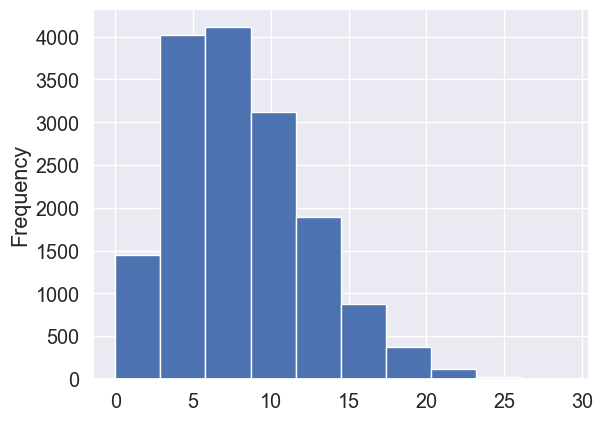

In [9]:
#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')

In [10]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()
    

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [12]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

In [13]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [14]:
# Encode labels
print(y_train)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)
y_train

0        sadness
1        sadness
2          anger
3           love
4          anger
          ...   
15964    sadness
15965    sadness
15966        joy
15967      anger
15968    sadness
Name: Emotion, Length: 15969, dtype: object


array([4, 4, 0, ..., 2, 0, 4])

In [15]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [16]:
print(y_train)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [17]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [18]:
tokenizer.document_count

17969

In [19]:
tokenizer.texts_to_sequences(X_train[0].split())

[[53], [2], [531]]

In [20]:
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
tokenizer.texts_to_matrix(X_train[0].split()).shape

(3, 14325)

In [22]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [23]:
df_test.shape

(2000, 2)

In [24]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

229

In [25]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 14325


In [26]:
sequences_train[0]

[53, 2, 531]

In [27]:
path_to_glove_file = 'glove.6B.100d.txt'
num_tokens = vocabSize
embedding_dim = 100 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [28]:
# Read word vectors
with open(path_to_glove_file,encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Found 400000 word vectors.
Converted 13243 words (1081 misses)


In [29]:

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 100, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
# model.add(Bidirectional(LSTM(64, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(32, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 229, 100)          1432500   
                                                                 
 bidirectional (Bidirection  (None, 229, 128)          84480     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 1558586 (5.95 MB)
Trainable params: 126086 (492.52 KB)
Non-trainable params: 1432500 (5.46 MB)
_________________________________________________________________


In [30]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [31]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=50,
                    epochs=7,
                    callbacks=[callback]
                   )

Epoch 1/7
320/320 [==============================] - 597s 2s/step - loss: 0.9671 - accuracy: 0.6371 - val_loss: 0.4220 - val_accuracy: 0.8585
Epoch 2/7
320/320 [==============================] - 617s 2s/step - loss: 0.3544 - accuracy: 0.8706 - val_loss: 0.2103 - val_accuracy: 0.9180
Epoch 3/7
320/320 [==============================] - 643s 2s/step - loss: 0.2100 - accuracy: 0.9178 - val_loss: 0.1773 - val_accuracy: 0.9220
Epoch 4/7
320/320 [==============================] - 690s 2s/step - loss: 0.1600 - accuracy: 0.9321 - val_loss: 0.1473 - val_accuracy: 0.9340
Epoch 5/7
320/320 [==============================] - 709s 2s/step - loss: 0.1348 - accuracy: 0.9387 - val_loss: 0.1301 - val_accuracy: 0.9310
Epoch 6/7
320/320 [==============================] - 747s 2s/step - loss: 0.1213 - accuracy: 0.9451 - val_loss: 0.1198 - val_accuracy: 0.9370
Epoch 7/7
320/320 [==============================] - 779s 2s/step - loss: 0.1159 - accuracy: 0.9455 - val_loss: 0.1266 - val_accuracy: 0.9355


In [32]:
model.evaluate(X_val, y_val, verbose=1) 

63/63 [==============================] - 35s 544ms/step - loss: 0.1266 - accuracy: 0.9355


[0.12663857638835907, 0.9355000257492065]

In [33]:
model.evaluate(X_test, y_test, verbose=1) 

63/63 [==============================] - 34s 541ms/step - loss: 0.1499 - accuracy: 0.9280


[0.14991454780101776, 0.9279999732971191]

In [34]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['Emotion']), y_pred))

63/63 [==============================] - 35s 535ms/step
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       275
           1       0.89      0.92      0.91       224
           2       0.96      0.93      0.94       695
           3       0.82      0.87      0.84       159
           4       0.95      0.97      0.96       581
           5       0.91      0.65      0.76        66

    accuracy                           0.93      2000
   macro avg       0.91      0.88      0.89      2000
weighted avg       0.93      0.93      0.93      2000



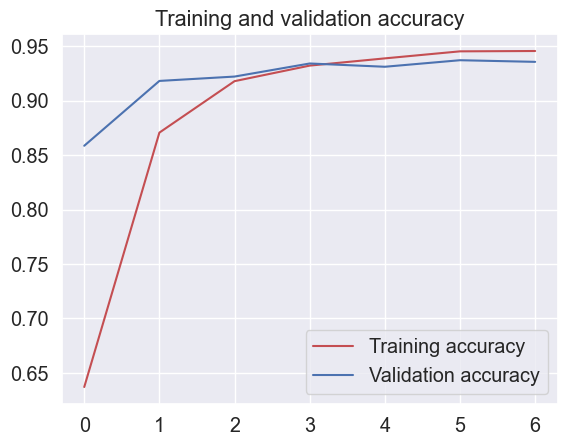

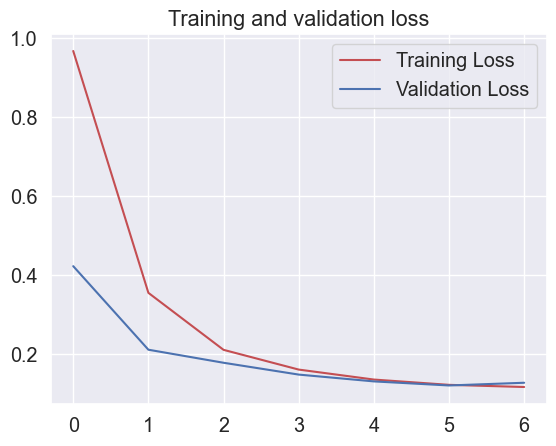

In [35]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
# sentence= 'Hosted a little surprise party for my dear friend Kamal. 🥳 Swipe for the reveal!'
# print(sentence)
# sentence = normalized_sentence(sentence)
# sentence = tokenizer.texts_to_sequences([sentence])
# sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
# result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
# proba =  np.max(model.predict(sentence))
# print(f"{result} : {proba}\n\n")

Hosted a little surprise party for my dear friend Kamal. 🥳 Swipe for the reveal!
1/1 [==============================] - 0s 59ms/step
anger : 0.6607057452201843




In [44]:
model.save("emotion_predict_model.h5")

C:\Users\ADITYA\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
import re
import string
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

# Function for text normalization
def normalize_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Function to predict emotion
def predict_emotion(text):
    # Load the trained model
    model = load_model('emotion_predict_model.h5')  # Replace with the path to your trained model

    # Text normalization
    normalized_text = normalize_text(text)

    # Tokenize and pad the input text
    tokenizer = Tokenizer(oov_token='UNK')
    tokenizer.fit_on_texts([normalized_text])
    sequences = tokenizer.texts_to_sequences([normalized_text])
    padded_sequences = pad_sequences(sequences, maxlen=229, truncating='pre')

    # Make the prediction
    predicted_probs = model.predict(padded_sequences)
    predicted_class = np.argmax(predicted_probs, axis=-1)

    # Map the predicted class back to the original emotion label (use the LabelEncoder)
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['anger','fear','joy','love','sadness','surprise'])  # Replace with your class labels
    predicted_emotion = label_encoder.inverse_transform(predicted_class)

    return predicted_emotion[0], predicted_probs[0]

# Example usage:
input_text = "cake"
predicted_emotion, predicted_probs = predict_emotion(input_text)
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Emotion Probabilities: {predicted_probs}")


1/1 [==============================] - 1s 880ms/step
Predicted Emotion: sadness
Emotion Probabilities: [0.13443848 0.11114135 0.2696692  0.07082653 0.31912252 0.0948019 ]


In [61]:
import pickle
model_filename = "emo_model.pkl"
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

In [62]:
# Save the Tokenizer as a .pkl file
tokenizer_filename = "tokenizer_emo.pkl"
with open(tokenizer_filename, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)
